# Notebook 06: Classification - Predicting Sales for New Models

This notebook develops a classification model and evaluates predictions for new model sales using attributes for watches in datasets cleaned in [Notebook 1: Data Cleaning](01_data_cleaning.ipynb).

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.compose import make_column_transformer
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, accuracy_score, balanced_accuracy_score, f1_score, roc_auc_score, roc_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier
from sklearn.impute import KNNImputer
from sklearn.feature_selection import RFE


# custom function imports
from custom_functions import *
from regression_custom_functions import *

In [2]:
# Import data
df_all_models = pd.read_csv('../data/cleaned_datasets/df_models.csv')

# Create a new dataframe with only models where there is historical sales data
time_now = datetime.datetime.now()
df_models = df_all_models.dropna(subset=time_now.strftime(f"%Y-%m"))

# Create new data frame with attributes from model to make predictions for new models in proposal
df_new_models = df_all_models[df_all_models[time_now.strftime(f"%Y-%m")].isna()]

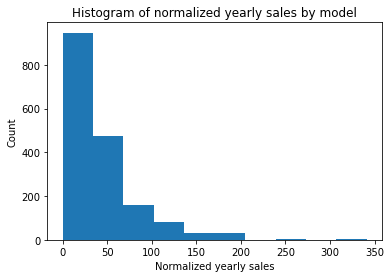

In [3]:
# Calculate a target value - Normalized Yearly Sales
df_models = calc_norm_yearly_sales(df_models, 4, 2019)

## Label models by normalized yearly sales

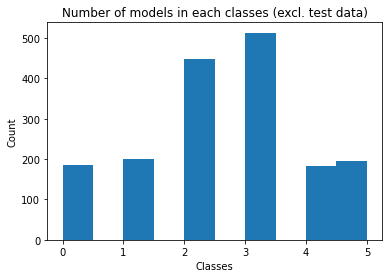

In [4]:
# Define upper bounds for normalized yearly sales to classify data
class_upper = {0:5,   # none
                   1:15,  # poor
                   2:30,  # fair
                   3:60, # average
                   4:90  # good
                  }       # excellent


# Use custom function and upper bounds to make classes
df_models['class'] = make_classes(df_models.norm_yearly_sales, class_upper)

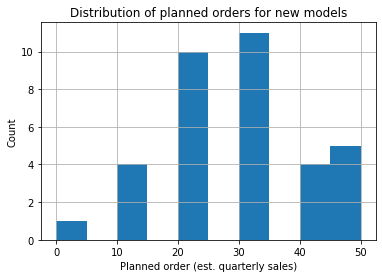

In [5]:
# compare to planned order for new models to check if similar distribution
df_new_models.planned_order.hist()
plt.title('Distribution of planned orders for new models')
plt.xlabel('Planned order (est. quarterly sales)')
plt.ylabel('Count');

## Baseline Model

In [6]:
# Create X & y for model creation using attributes
attributes = ['country_of_origin','warranty', 'band_color', 'band_material',
       'case_material', 'dial_color', 'case_size', 'gender', 'color',
       'retail_price', 'collection', 'clasp_type', 'water_resistance',
       'movement_type']

X = df_models[attributes]
y = df_models['class']

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Check no null values in X
X.isna().sum().sum() #Should return 0

0

In [7]:
# Create test set for later model testing
test = df_new_models[attributes]

# Impute missing retail prices
knn_imp = KNNImputer()
test['retail_price'] = knn_imp.fit_transform(test[['retail_price']])

# Check no null values in test
test.isna().sum().sum() #Should return 0

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_33730/1977101099.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['retail_price'] = knn_imp.fit_transform(test[['retail_price']])


0

In [8]:
# Check for distribution of classes
test_counts = y_test.value_counts(normalize=True)
test_counts

2    0.292343
3    0.292343
1    0.122970
4    0.113689
0    0.092807
5    0.085847
Name: class, dtype: float64

While the classes are imbalanced, I do not think this will significantly impact the model so I will not implement any techniques to create a balanced dataset. I will use an f1 score as well as accuracy as metrics to evaluate models due to the imbalanced nature.

In [9]:
baseline_preds = np.full_like(y_test,test_counts.index[0])

baseline_accuracy = test_counts[0]/sum(test_counts)
baseline_f1 = f1_score(y_test, baseline_preds, average='weighted')

print(f'Baseline accuracy is {round(baseline_accuracy*100,1)}%.')
print(f'Baseline f1 score is {round(baseline_f1*100,1)}%.')

Baseline accuracy is 9.3%.
Baseline f1 score is 13.2%.


## Exploring different models

LogisticRegression(max_iter=1000)


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train accuracy: 0.7416860015467904
Test accuracy: 0.35730858468677495
Test f1 score: 0.3540670887880754

KNeighborsClassifier()
Train accuracy: 0.5808197989172467
Test accuracy: 0.3248259860788863
Test f1 score: 0.3204454287269241

RandomForestClassifier(n_estimators=200)


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train accuracy: 0.9203402938901779
Test accuracy: 0.3851508120649652
Test f1 score: 0.3763515743228728

AdaBoostClassifier(base_estimator=LogisticRegression())


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train accuracy: 0.522815158546017
Test accuracy: 0.37354988399071926
Test f1 score: 0.37374159525051787

ExtraTreesClassifier(n_estimators=200)


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train accuracy: 0.9203402938901779
Test accuracy: 0.3805104408352668
Test f1 score: 0.37382486639430407

Best test accuracy: 0.3851508120649652
Best model: Pipeline(steps=[('ct',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country_of_origin',
                                                   'warranty', 'band_color',
                                                   'band_material',
                                                   'case_material',
                                                   'dial_color', 'case_size',
                                                   'gender', 'color',
                         

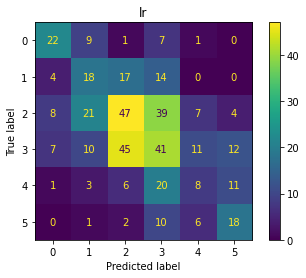

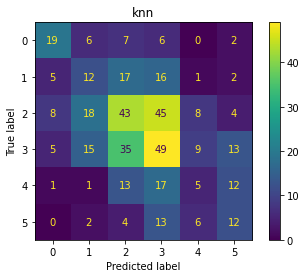

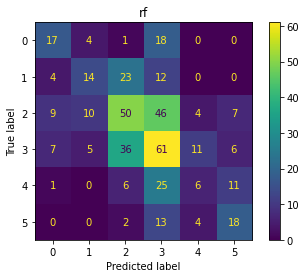

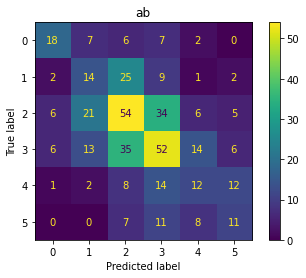

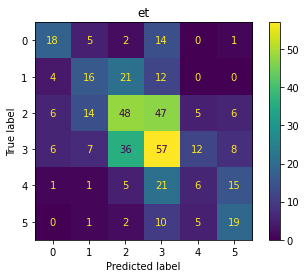

In [10]:
# Instantiate various model types to feed into a function that creates and evaluates various the models
# This will be used to quickly narrow down models that will be further tuned for a final production model
models = [('lr',LogisticRegression(max_iter=1_000)),('knn',KNeighborsClassifier()),
          ('rf', RandomForestClassifier(n_estimators=200)), ('ab', AdaBoostClassifier(base_estimator=LogisticRegression())),
          ('et', ExtraTreesClassifier(n_estimators=200))]

best_accuracy = baseline_accuracy
best_model = 'baseline'
df_preds = pd.DataFrame(y_test.values, columns=['y_test'])

for model in models:
    pipe, preds, test_accuracy = create_evaluate_model_class(model, X_train, X_test, y_train, y_test)
    df_preds[f'preds_{model[0]}'] = preds
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        best_model = pipe
        
print('Best test accuracy:', best_accuracy)
print('Best model:', best_model)

## Developing a Production model

Based on the results and f1 scores of the exploration, I will narrow down selection of a few models and try a voting classifier to try to improve the accuracy and f1 score, and increase bias.

#### Logistic Regression

LogisticRegressionCV(max_iter=1000, n_jobs=-1, random_state=42)


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train accuracy: 0.6403712296983759
Test accuracy: 0.38979118329466356
Test f1 score: 0.37765502887786456



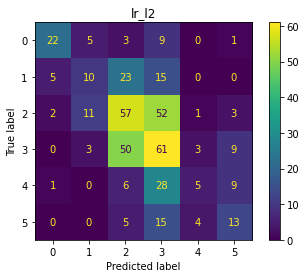

In [11]:
# Trying Logistic Regression CV with l2 regularization
pipe_l2, preds_l2, test_accuracy_l2 = create_evaluate_model_class(('lr_l2',LogisticRegressionCV(max_iter=1000,n_jobs = -1, random_state=42)), X_train, X_test, y_train, y_test);

LogisticRegressionCV(n_jobs=-1, penalty='l1', random_state=42, solver='saga',
                     tol=0.1)


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train accuracy: 0.6395978344934261
Test accuracy: 0.37819025522041766
Test f1 score: 0.37070452717951574



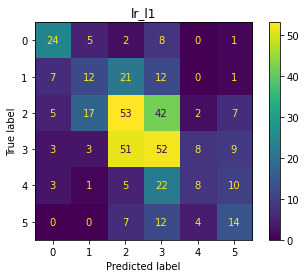

In [12]:
# Trying Logistic Regression CV with l1 regularization
pipe_l1, preds_l1, test_accuracy_l1 = create_evaluate_model_class(('lr_l1',LogisticRegressionCV(tol = 0.1, penalty='l1',solver='saga',n_jobs = -1,refit=True, random_state=42)), X_train, X_test, y_train, y_test);

##### Compare the individual scores across each C for L1 and L2

In [13]:
get_Cs_scores(pipe_l2, 'lr_l2')

{0.0001: 0.2993026248840202,
 0.000774263682681127: 0.37819879680344803,
 0.005994842503189409: 0.4114543114543114,
 0.046415888336127774: 0.3944389572296549,
 0.3593813663804626: 0.38281703630540836,
 2.782559402207126: 0.37431085570620454,
 21.54434690031882: 0.3681542007123403,
 166.81005372000558: 0.3573284247702852,
 1291.5496650148827: 0.3596659782706294,
 10000.0: 0.3596569991918829}

In [14]:
get_Cs_scores(pipe_l1, 'lr_l1')

{0.0001: 0.2993026248840202,
 0.000774263682681127: 0.2993026248840202,
 0.005994842503189409: 0.2993026248840202,
 0.046415888336127774: 0.3890036215617611,
 0.3593813663804626: 0.4091257370327138,
 2.782559402207126: 0.40294513782885877,
 21.54434690031882: 0.4037143455748106,
 166.81005372000558: 0.4037143455748106,
 1291.5496650148827: 0.40990990990990983,
 10000.0: 0.4145491005956122}

Between L1 and L2, L2 had the strongest score at 0.006, but it is not as stable as the highest score with L1 over 0.35. I will continue to explore L1 over a more narrow range:

LogisticRegressionCV(Cs=[0.05, 0.1, 0.25, 0.35, 0.45, 0.75, 1, 2, 3, 4, 5],
                     n_jobs=-1, penalty='l1', random_state=42, solver='saga',
                     tol=0.1)


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train accuracy: 0.6388244392884764
Test accuracy: 0.3805104408352668
Test f1 score: 0.37285789043853185



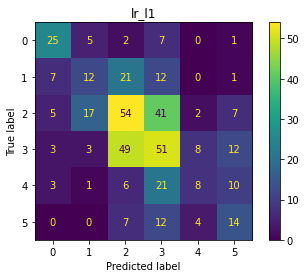

In [15]:
# Trying Logistic Regression CV with l1 regularization
pipe_l1, preds_l1, test_accuracy_l1 = create_evaluate_model_class((
    'lr_l1',LogisticRegressionCV(Cs=[0.05,0.1,0.25,0.35,0.45,0.75,1,2,3,4,5],
                                 tol = 0.1, penalty='l1',solver='saga',
                                 n_jobs = -1,refit=True, random_state=42)),
    X_train, X_test, y_train, y_test);

In [16]:
get_Cs_scores(pipe_l1, 'lr_l1')

{0.05: 0.3936487982999611,
 0.1: 0.3920984107030619,
 0.25: 0.399063182784113,
 0.35: 0.3975157882134627,
 0.45: 0.3959803657478076,
 0.75: 0.4029421448026099,
 1.0: 0.404495525425758,
 2.0: 0.4106791176558618,
 3.0: 0.4106791176558618,
 4.0: 0.4068061416898626,
 5.0: 0.40835353626051296}

Based on the new L1 scores, I will select a C of 4 (higher regularization, which could be helpful in increasing bias in the model)

LogisticRegression(C=4, n_jobs=-1, penalty='l1', random_state=42, solver='saga',
                   tol=0.1)
Train accuracy: 0.6133023975251354
Test accuracy: 0.38979118329466356


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test f1 score: 0.3798578050410647



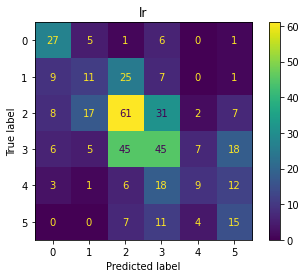

In [17]:
# Final L1 model
model_lr = ('lr',LogisticRegression(tol = 0.1, C = 4, penalty='l1',solver='saga',n_jobs = -1,random_state=42))
pipe_lr, preds_lr, test_accuracy_lr = create_evaluate_model_class(
    model_lr,
    X_train, X_test, y_train, y_test);

In [18]:
df_coefs_lr = get_coefs(pipe_lr, 'lr')
df_coefs_lr.sort_values(by='coefs_class_5')

,coefs_class_0,coefs_class_1,coefs_class_2,coefs_class_3,coefs_class_4,coefs_class_5
clasp_type_buckle,0.085584,0.088358,0.044767,-0.055416,-0.068674,-0.094572
water_resistance_3 atm,-0.011135,0.007410,0.004544,0.034691,0.024060,-0.060423
band_material_leather,0.034484,0.050589,0.050825,-0.042184,-0.040507,-0.053183
case_size_28.0,-0.018907,-0.000434,0.025627,0.019955,0.023080,-0.049328
case_size_32.0,0.007194,0.036317,-0.023048,0.043757,-0.017594,-0.046522
...,...,...,...,...,...,...
dial_color_gold,-0.018045,0.009034,-0.026300,-0.017005,-0.032189,0.085504
collection_stellasport,-0.012017,-0.007244,-0.020643,-0.036766,-0.010983,0.089809
band_material_stainless steel,-0.028816,-0.078224,-0.091852,0.057925,0.048973,0.092012
case_size_50.0,-0.029367,-0.015386,-0.034848,-0.004099,-0.013228,0.098873


#### Extra Trees Classifier

Between Random Forest and Extra Trees, I will choose to explore extra trees further because they had similar performance, and Extra Trees adds some randomization since it chooses the split point randomly (and because it is faster).

In [19]:
# # Conducting a grid search on extra trees
# param_grid = {'et__max_features':['auto', 'sqrt','log2'],
#               'et__criterion':['gini', 'entropy'],
#               'et__class_weight': [None,"balanced","balanced_subsample"]}
              
# # Create a column transformer to one hot encode categorical variables
# categorical_attributes = []
# for attribute in X_train.columns:
#     try:
#         int(attribute)
#     except:
#         categorical_attributes.append(attribute)

# ct = ColumnTransformer([('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'),
#                      categorical_attributes)],
#                   remainder='passthrough',
#                   verbose_feature_names_out=False)

# # Create a pipeline to transform, scale, and model
# pipe_et = Pipeline([
#     ('ct',ct),
#     ('ss',StandardScaler()),
#     ('et',ExtraTreesClassifier(n_jobs = -1,random_state=42,warm_start=True,max_depth=15))
# ])
    
# pipe_gs_et = GridSearchCV(pipe_et, param_grid = param_grid,error_score='raise')

# # Fit model with training data
# pipe_gs_et.fit(X_train,y_train)

# # Print traw and test score
# test_accuracy = pipe_gs_et.score(X_test,y_test)
# print('Train accuracy:', pipe_gs_et.score(X_train,y_train))
# print('Test accuracy:', test_accuracy)

# # Create predictions with test data
# preds = pipe_gs_et.predict(X_test)

# # Evaluate predictions
# print('Test f1 score:', f1_score(y_test, preds, average='weighted'))

# # Generate confusion matrix
# ConfusionMatrixDisplay.from_predictions(y_test,preds)
# plt.title(model[0])

In [20]:
# pipe_gs_et.best_estimator_ 
# Pipeline(steps=[('ct',
#                  ColumnTransformer(remainder='passthrough',
#                                    transformers=[('ohe',
#                                                   OneHotEncoder(drop='first',
#                                                                 handle_unknown='ignore',
#                                                                 sparse=False),
#                                                   ['country_of_origin',
#                                                    'warranty', 'band_color',
#                                                    'band_material',
#                                                    'case_material',
#                                                    'dial_color', 'case_size',
#                                                    'color', 'retail_price',
#                                                    'collection', 'clasp_type',
#                                                    'water_resistance',
#                                                    'movement_type'])],
#                                    verbose_feature_names_out=False)),
#                 ('ss', StandardScaler()),
#                 ('et',
#                  ExtraTreesClassifier(criterion='entropy', max_depth=15,
#                                       n_jobs=-1, random_state=42,
#                                       warm_start=True))])

ExtraTreesClassifier(criterion='entropy', max_depth=15, n_estimators=500,
                     n_jobs=-1, random_state=42)


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train accuracy: 0.8762567672080434
Test accuracy: 0.4037122969837587
Test f1 score: 0.3834403323028712


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


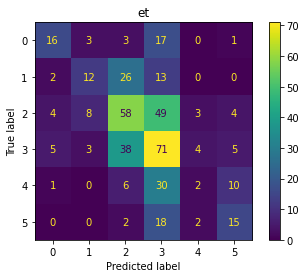

In [21]:
# Final extra trees classifier model
model_et = ('et',ExtraTreesClassifier(criterion='entropy', max_depth=15,
                                      n_estimators=500, n_jobs=-1,
                                      random_state=42))
pipe_et, preds_et, test_accuracy_et = create_evaluate_model_class(model_et
                 , X_train, X_test, y_train, y_test);

#### Testing a voting classifier with logistic regression

VotingClassifier(estimators=[('et',
                              ExtraTreesClassifier(criterion='entropy',
                                                   max_depth=15,
                                                   n_estimators=500, n_jobs=-1,
                                                   random_state=42)),
                             ('lr',
                              LogisticRegression(C=4, n_jobs=-1, penalty='l1',
                                                 random_state=42, solver='saga',
                                                 tol=0.1))],
                 n_jobs=-1, voting='soft', weights=[6, 1])


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Train accuracy: 0.8754833720030936
Test accuracy: 0.4060324825986079


/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [2, 4, 9, 10] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Test f1 score: 0.3869863614595649



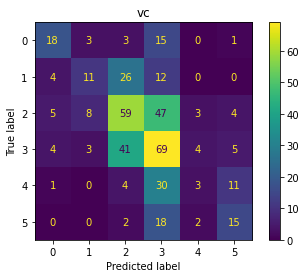

In [22]:
# Experimenting with a voting classifier for the models
model_vc = ('vc',VotingClassifier([model_et, model_lr],
    n_jobs=-1,
    voting = 'soft',
    weights = [6,1]
))

# Fit and evaluate model
pipe_vc, preds_vc, test_accuracy_vc = create_evaluate_model_class(
    model_vc,
    X_train, X_test, y_train, y_test);

Tried:
- ('et',ExtraTreesClassifier(criterion='entropy', max_depth=15, n_estimators=200, n_jobs=-1, random_state=42))
Train accuracy: 0.7996906419180201
Test accuracy: 0.3874709976798144
Test f1 score: 0.3669389760023724
- ('et',ExtraTreesClassifier(n_jobs=-1, random_state=42)):
Train accuracy: 0.9203402938901779
Test accuracy: 0.3874709976798144
Test f1 score: 0.38068259110237207
- ('rf',RandomForestClassifier(n_jobs=-1, random_state=42))
Train accuracy: 0.9164733178654292
Test accuracy: 0.3851508120649652
Test f1 score: 0.37706929392554334

Narrowed down on and tried various weights
- ('et',ExtraTreesClassifier(criterion='entropy', max_depth=15,n_estimators=500, n_jobs=-1, random_state=42))
- Weights - optimal location was [6,1]

### Production model

In [23]:
# Create a column transformer to one hot encode categorical variables
categorical_attributes = []
for attribute in X_train.columns:
    try:
        int(attribute)
    except:
        categorical_attributes.append(attribute)

# Setup pipeline for preprocessing and modeling
ct = ColumnTransformer([('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'),
                         categorical_attributes)],
                      remainder='passthrough',
                      verbose_feature_names_out=False)
pipe = Pipeline([
    ('ct',ct),
    ('ss',StandardScaler()),
    model_vc
])

# Fit model with train set
pipe.fit(X_train,y_train)

# Generate predictions for new models
preds = pipe.predict(test)

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:170: UserWarning: Found unknown categories in columns [6, 10, 11] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


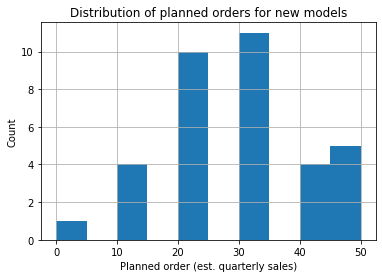

In [24]:
df_new_models.planned_order.hist()
plt.title('Distribution of planned orders for new models')
plt.xlabel('Planned order (est. quarterly sales)')
plt.ylabel('Count');

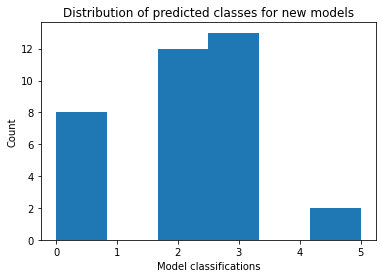

In [25]:
plt.hist(preds, bins=6)
plt.title('Distribution of predicted classes for new models')
plt.xlabel('Model classifications')
plt.ylabel('Count');

The distribution doesn't quite match up. The model is more likely to classify the new models in the 0 order bucket, and less likely to place large orders. This will be an optimization for a later time.

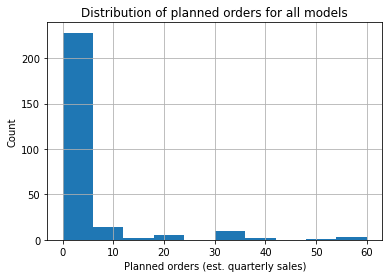

In [26]:
df_models.planned_order.hist()
plt.title('Distribution of planned orders for all models')
plt.xlabel('Planned orders (est. quarterly sales)')
plt.ylabel('Count');

In [32]:
# Save new model predictions (monthly order) to csv
new_model_predictions = df_new_models[['style_id']]
new_model_predictions[f'monthly_classifications_Q{(time_now.month - 1 ) // 3 + 1 + 1}'] = preds

new_model_predictions.to_csv('../data/predictions/new_models_classifications.csv',index=False)

/var/folders/0z/k5klxhhj5j9g8hc5ygn0nwsr0000gn/T/ipykernel_33730/449321751.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_model_predictions[f'monthly_classifications_Q{(time_now.month - 1 ) // 3 + 1 + 1}'] = preds
